# Elasticity equation

In this tutorial we present how to solve the elasticity equation with [PorePy](https://github.com/pmgbergen/porepy) and then how to use [PyGeoN](https://github.com/compgeo-mox/pygeon) to post process the stresses.  The unknown is the displacement $u$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$\lambda$ Lamé constant and $\mu$ the Kirchhoff modulus, we want to solve the following problem: find $u$ such that
$$
\nabla \cdot [ 2 \mu \epsilon(u) + \lambda \nabla \cdot u I] = -b
$$
with $\epsilon$ the symmetric gradient and $b$ a body force, which is set to $0$ in this example.
For this test case we set the following boundary conditions related to the so-called footstep problem:
$$ u = 0 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot \sigma = [0, 0]^\top \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \qquad \nu \cdot \sigma = [0, -1e-3]^\top \text{ on } \partial_{top} \Omega$$
where $\sigma = 2 \mu \epsilon(u) + \lambda \nabla \cdot u I$ is the stess tensor.

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [ ]:
import os

import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

We create now the grid. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 3d and for other types of grids.

In [12]:
N = 10
dim = 2

sd = pp.CartGrid([N] * dim, [1] * dim)
pg.convert_from_pp(sd)
sd.compute_geometry()

With the following code we set the data, in particular the Lamé and the Kirchhoff modulus, and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [ ]:
key = "elasticity_fv"

# Create stiffness matrix
lambda_ = np.ones(sd.num_cells)
mu = np.ones(sd.num_cells) / 2
C = pp.FourthOrderTensor(mu, lambda_)

# Define boundary type
b_faces = sd.get_all_boundary_faces()
num_b_faces = b_faces.size
labels = np.array(["neu"] * num_b_faces)

bottom = np.isclose(sd.face_centers[1, b_faces], 0)
labels[bottom] = "dir"
bound = pp.BoundaryConditionVectorial(sd, b_faces, labels)

bc_values = np.zeros((sd.dim, sd.num_faces))

top = np.isclose(sd.face_centers[1, :], 1)
bc_values[1, top] = -1e-3 * sd.face_areas[top]
bc_values = bc_values.ravel("F")

# No source term
source = np.zeros(sd.num_cells * sd.dim)

parameters = {
    "fourth_order_tensor": C,
    "bc_values": bc_values,
    "bc": bound,
    "source": source,
}
data = pp.initialize_data({}, key, parameters)

Once the data are assigned to the grid, we construct the matrices. Once the latter is created, we also construct the right-hand side containing the boundary conditions.

In [14]:
# discretize and solve the system
mpsa = pp.Mpsa(key)
mpsa.discretize(sd, data)

A, b = mpsa.assemble_matrix_rhs(sd, data)
u = sps.linalg.spsolve(A, b)

We first compute the traction for each face of the cell and reshape it so that it has the x-components for all the faces first and then all the y-components (and then all z-components in 3d case).

In [15]:
# post process the traction for each face
mat = data[pp.DISCRETIZATION_MATRICES][key]
mat_stress = mat[mpsa.stress_matrix_key]
mat_bound_stress = mat[mpsa.bound_stress_matrix_key]

# The measure is in Pascals
t = mat_stress @ u + mat_bound_stress @ bc_values

# reshape the traction to be in the order of first all the x-components, then all the y-components
t = np.reshape(t, (sd.dim, -1), order="F").ravel()

 Compute now the stress tensor, one `sd.dim` x `sd.dim` tensor per cell.

In [16]:
# vecRT0 = pg.VecRT0(key) # this is for simplices
vecRT0 = pg.VecVRT0(key)  # for general grids using vem
P0 = vecRT0.eval_at_cell_centers(sd)
cell_sigma = P0 @ t

# first we reshape sigma for each dimension and then split agin for each cell, so that we
# have for the 2d case
# [xx, xy, xz]*cells + [yx, yy, yz]*cells -> [[xx, xy, xz]*cells, [yx, yy, yz]*cells]
# [[xx, xy, xz]*cells, [yx, yy, yz]*cells] -> [[xx, xy, xz], [yx, yy, yz]]*cells
cell_sigma = np.array(np.hsplit(cell_sigma.reshape(sd.dim, -1), sd.num_cells))

# we can remove the z component to have it sd.num_cells x sd.dim x sd.dim
cell_sigma = cell_sigma[:, :, : sd.dim]

# we can split the tensor in each component
cell_sigma_xx = cell_sigma[:, 0, 0]
cell_sigma_xy = cell_sigma[:, 0, 1]
cell_sigma_yy = cell_sigma[:, 1, 1]

We finally export the solution.

In [ ]:
# reshape the displacement for the export
u = np.reshape(u, (sd.dim, -1), order="F")
u = np.vstack((u, np.zeros(sd.num_cells)))

# export the solution
folder_name = os.path.join(os.getcwd(), key)
file_name = "sol"

save = pp.Exporter(sd, file_name, folder_name=folder_name)
save.write_vtu(
    [
        ("u", u),
        ("cell_sigma_xx", cell_sigma_xx),
        ("cell_sigma_xy", cell_sigma_xy),
        ("cell_sigma_yy", cell_sigma_yy),
    ]
)

A representation of the computed solution is given below.

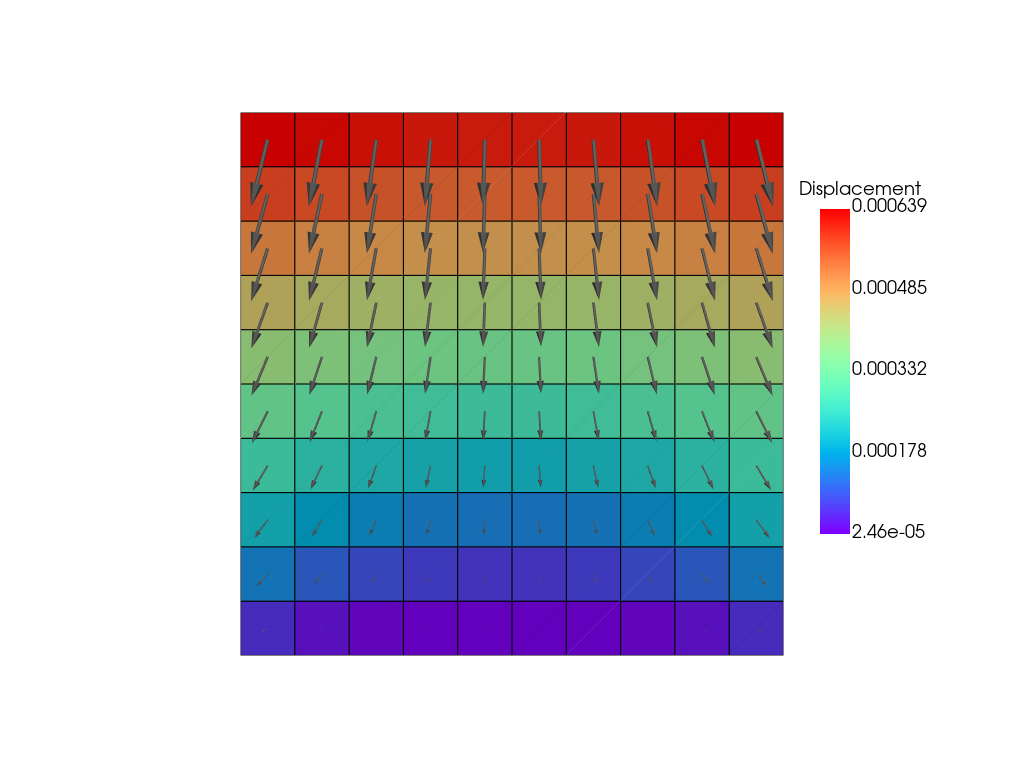

In [ ]:
# NBIGNORE
import pyvista as pv

file_vtu = os.path.join(folder_name, file_name + "_2.vtu")
mesh = pv.read(file_vtu)

plotter = pv.Plotter(off_screen=True, notebook=True)

# Glyphs scaled by magnitude
arrows = mesh.glyph(orient="u", scale="u", factor=200)
plotter.add_mesh(arrows, color="gray")

# Mesh colored by displacement magnitude
bar = {"title": "Displacement", "vertical": True, "position_x": 0.8, "position_y": 0.3}
plotter.add_mesh(
    mesh, scalars="u", cmap="rainbow", show_edges=True, scalar_bar_args=bar
)

# Show the result
plotter.view_xy()
plotter.enable_parallel_projection()
plotter.show(jupyter_backend="static")


In [25]:
# Consistency check
assert np.isclose(np.linalg.norm(u), 0.0037904633073553894)
